In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# The Autoencoder Zoo
**Author**: Jannick Stranghöner | SoSe23 | 23.05.2023

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/torchgan/torchgan/blob/master/tutorials/Tutorial%205.%20Adversarial%20Autoencoder.ipynb)

---

This tutorial gives a brief introduction into the world of Autoencoders, including the standard architecture, some of their exotic variants as well as their uses and shortcomings. This notebook is primarely based on [this](https://arxiv.org/pdf/1511.05644.pdf) paper by Makhzani & Goodfellow (2016), which I highly recommend for anyone interested in Autoencoders.

Let's Go!



## How to use this Notebook
This notebook contains the implementation of all algorithms, but for data loading, preprocessing and visualizuation we will need to clone one of my repositories into your session.

In [1]:
!git clone https://github.com/JannickS1812/Adversarial-Autoencoder AAE

Cloning into 'AAE'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 47 (delta 8), reused 28 (delta 5), pack-reused 16
Unpacking objects: 100% (47/47), 159.14 MiB | 7.30 MiB/s, done.
Updating files: 100% (26/26), done.


This tutorial assumes that you run the code on a hosted runtime, which contains all the packages you need. Should you connect to your local IPython runtime, make sure to have [PyTorch](https://pytorch.org/get-started/locally/) installed.

In [2]:
try:
    import torch
    print(f"Existing Torch {torch.__version__} installation found")

except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "pip3", "install", "torch", "--index-url", r"https://download.pytorch.org/whl/cu117"])

    import torch
    print(f"Installed Torch {torch.__version__}")

Existing Torch 2.0.0+cu118 installation found


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

from AAE import dataflow
from AAE import plotting

ModuleNotFoundError: ignored

# Introduction

### Autoencoder

---

Imagine a scenario where you have a complex piece of artwork, and you want to find a way to represent it using fewer brushstrokes or pixels. Intuitively, you might expect that by reducing the level of detail, you would lose important information, making the reconstructed artwork appear significantly different from the original. 

This is precisely what autoencoders aim to accomplish. They are neural networks designed to reconstruct their input data as accurately as possible, aiming for the output to be **identical** to the input.



---

<img src="https://github.com/JannickS1812/Adversarial-Autoencoder/blob/main/img/AE_fixed.png?raw=true" alt= “” width=500 height="value">

The secret lies in the architecture of the autoencoder, which consists of two main components: an `encoder` and a `decoder`. The encoder maps the input data $\mathbf{x}$ into a `lower-dimensional latent space representation` $\mathbf{z}$. This compressed representation, often called a bottleneck, captures the essential features of the input. Then, the decoder takes the latent representation and reconstructs the original data from it.

Think of autoencoders as a data compression algorithm, like a .zip file. When you want to store or transmit a large file, you can compress it to a smaller size without losing essential information. Autoencoders work in a similar way, but instead of compressing files, they compress data by `learning efficient representations`. 

Other uses besides non-linear dimensionality reduction are 
 

*   `anomaly detection` (you only reconstruct stuff with low error if you have seen it before)
*   `denoising` (by adding gaussian noise to the input images)
*   `generative purposes` (we will come to that later)


---

The key idea is the Manifold Hypothesis:

`High dimensional data can be embedded as a low dimensional manifold inside the high dimensional space`

![alt-text](https://golden-storage-production.s3.amazonaws.com/topic_images/c4c469bb2a4b4630832a282d938fcf1d.png)

Let's implement this!

We will start by defining a few global variables and loading our beloved MNIST dataset.

In [ ]:
# A few global settings
global_num_neurons = 1000
global_num_classes = 10
global_num_latent = 2
epochs = 100
batch_size = 1000

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
mnist_train,mnist_test,mnist_vis_test,mnist_vis_train = dataflow.load_MNIST()

data_loader = torch.utils.data.DataLoader(mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

data_plot = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 103271370.52it/s]


Extracting C:\Git\UNI\39-M-Inf-VML Vertiefung Maschinelles Lernen\Exercise Adversial Autoencoders\MNIST/MNIST/raw/train-images-idx3-ubyte.gz to C:\Git\UNI\39-M-Inf-VML Vertiefung Maschinelles Lernen\Exercise Adversial Autoencoders\MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33658153.33it/s]


Extracting C:\Git\UNI\39-M-Inf-VML Vertiefung Maschinelles Lernen\Exercise Adversial Autoencoders\MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to C:\Git\UNI\39-M-Inf-VML Vertiefung Maschinelles Lernen\Exercise Adversial Autoencoders\MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27508089.86it/s]


Extracting C:\Git\UNI\39-M-Inf-VML Vertiefung Maschinelles Lernen\Exercise Adversial Autoencoders\MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to C:\Git\UNI\39-M-Inf-VML Vertiefung Maschinelles Lernen\Exercise Adversial Autoencoders\MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3733201.80it/s]


Extracting C:\Git\UNI\39-M-Inf-VML Vertiefung Maschinelles Lernen\Exercise Adversial Autoencoders\MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to C:\Git\UNI\39-M-Inf-VML Vertiefung Maschinelles Lernen\Exercise Adversial Autoencoders\MNIST/MNIST/raw



The loss function of the auto encoder is called the **reconstruction loss** and in the general case is written as: $\mathcal{L}(x,\hat{x})$. Euclidian distance is common here, however, in our case, where we exclusively deal with normalized grayscale images and apply a sigmoid activation in the model's final layer, we can also employ binary cross-entropy as an alternative metric.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n, z, hidden):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(n, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, z)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)

        return x


class Decoder(nn.Module):
    def __init__(self, n, z, hidden):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(z, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, n)

        self.act_rel = nn.ReLU()
        self.act_sig = nn.Sigmoid()

    def forward(self, x):
        x = self.act_rel(self.fc1(x))
        x = self.act_rel(self.fc2(x))
        x = self.act_sig(self.fc3(x))
        return x


class AutoEncoder(nn.Module):

    def __init__(self, n, z, hidden):
        super(AutoEncoder, self).__init__()
        self.enc = Encoder(n, z, hidden)
        self.dec = Decoder(n, z, hidden)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def decode(self, x):
        x = self.dec(x)
        return x

    def encode(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.enc(x)
        return x

In [ ]:
ae = AutoEncoder(784,global_num_latent,global_num_neurons)
ae.to(device)

AutoEncoder(
  (enc): Encoder(
    (fc1): Linear(in_features=784, out_features=1000, bias=True)
    (fc2): Linear(in_features=1000, out_features=1000, bias=True)
    (fc3): Linear(in_features=1000, out_features=2, bias=True)
    (act): ReLU()
  )
  (dec): Decoder(
    (fc1): Linear(in_features=2, out_features=1000, bias=True)
    (fc2): Linear(in_features=1000, out_features=1000, bias=True)
    (fc3): Linear(in_features=1000, out_features=784, bias=True)
    (act_rel): ReLU()
    (act_sig): Sigmoid()
  )
)

In [ ]:
crit = nn.BCELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

running_loss = 0.0
hist_loss = []
n_batch = 0

for epoch in range(epochs):
  for data,_ in data_loader:
    data = data.to(device)

    optimizer.zero_grad()
    
    # forward + backward + optimize
    outputs = ae(data)
    loss = crit(outputs, torch.flatten(data,start_dim=1))
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    n_batch += 1

  print(f'[{epoch + 1}] loss: {running_loss / n_batch:.3f}')
  hist_loss += [running_loss / n_batch]
  running_loss = 0.0
  n_batch = 0

KeyboardInterrupt: ignored

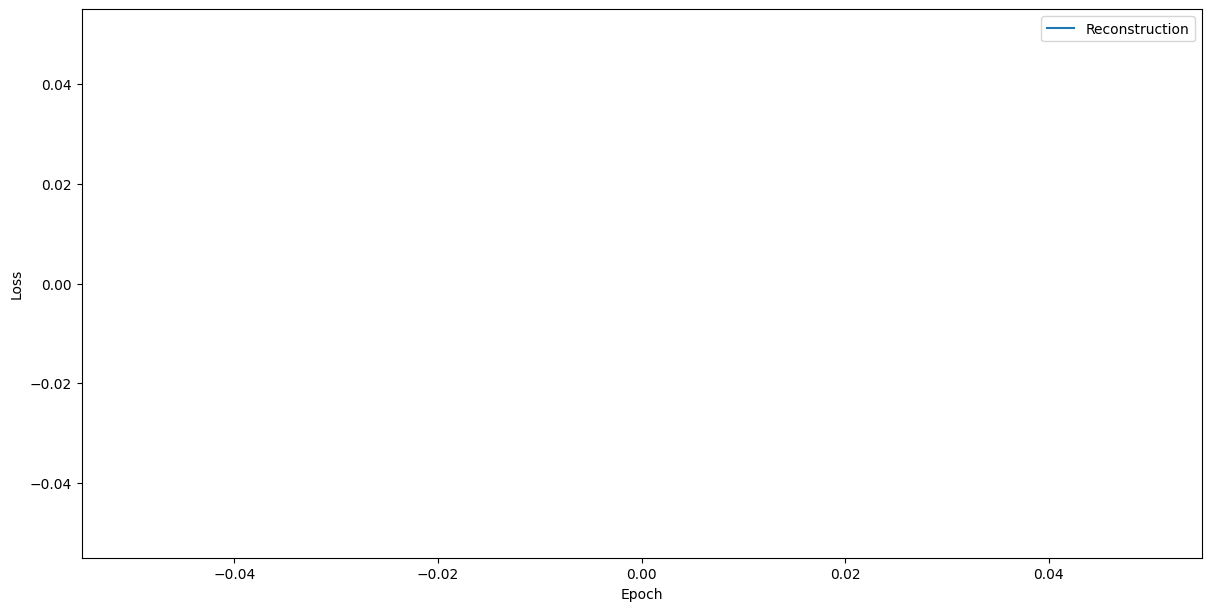

In [ ]:
plotting.vis_training(Reconstruction=hist_loss)

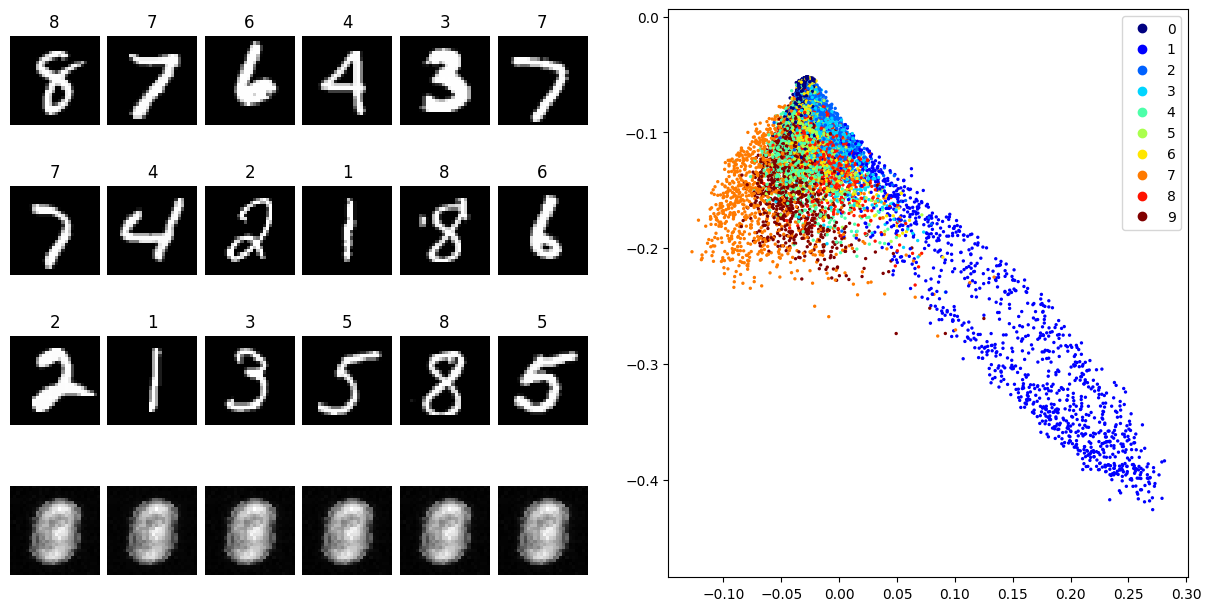

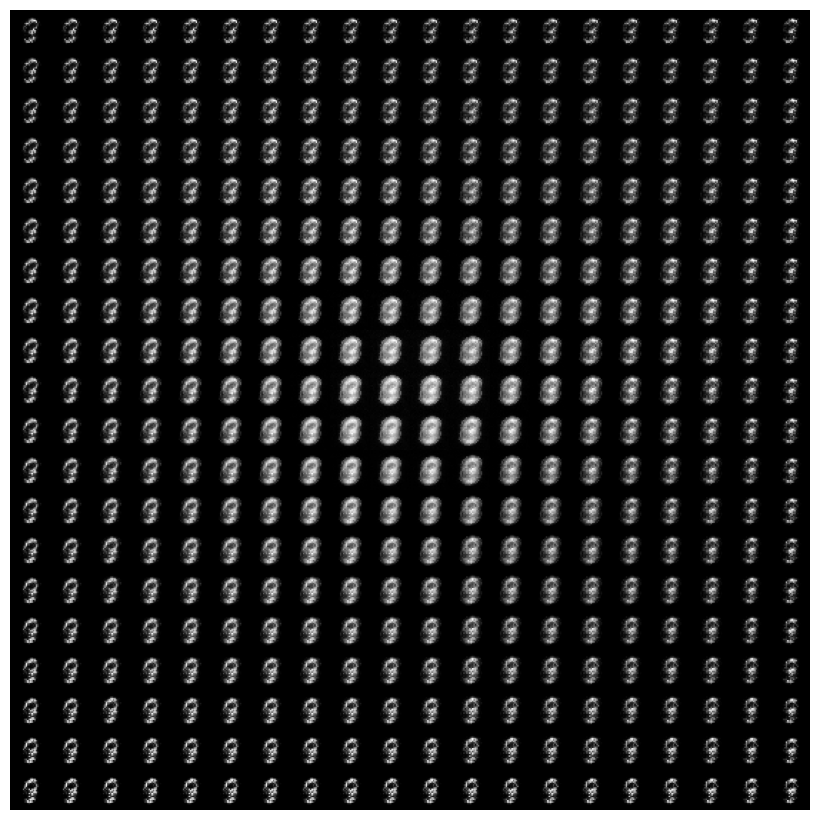

In [ ]:
plotting.visualize(ae, data_plot, mnist_vis_test, device=device)

### Plot Explanation
-- will be the same for the following models so this is only mentioned once --

1.  Sample images from MNIST, last row is the model reconstruction `[Upper Left]`
2. Latent space distribution generated by the encoder over the test dataset `[Upper Right]`
3. Sampling the manifold, here we sample the gaussian percentiles of $N(0,5)$ `[Lower]`

It is evident that the Auto Encoder has no problems to reconstruct the images quite well, especially considering this network does **not use convolution!** Yet it fails to properly model the data within the latent space "in a meaningful way". But what does this mean?

In a generative setting, where we would sample from the latent space and decode that sample into an image, we wouldn't know where to look, (Imagine the latent space would not be 2, but 10-dimensional), nor do we know how to interpolate between 2 representations (is the path inbetween meaningful?). 

This is especially evident looking at the encoding plot above. The goal is to impose a useful **structure** on this latent space that enables a smooth representation.


### Summary

Limitations:
- **Representation:** How to sample from our latent space to generate new data?
- **Interpolation:** Are we able to interpolate between 2 latent representations?

Solution / Approach:
- Latent space should be **smooth**: impose a **probability distribution**Soltuo
- But how? Different approaches possible, via regularization -> **Variational Auto Encoder**

#($\beta$-) Variational Autoencoder

<img src="https://github.com/JannickS1812/Adversarial-Autoencoder/blob/main/img/VAE_fixed.png?raw=true" alt= “” width=500 height="value">

### Idea
- Learn mean and standard deviation of a distribution from which to sample
- Regularize by distance of learned distribution to given normal distribution


Note: To allow backpropagation through sampling the `reparameterization trick` is used. Instead of sampling directly we sample $\epsilon\sim N(0,1)$ and calculate our sample as follows: $z = \mu + \sigma \odot \epsilon$, where $\odot$ denotes the element wise product.

### Modified Loss
The loss of the VAE is equal to the reconstruction loss regularized by the ($\beta$ scaled)  Kuller-Leiback divergence, thus we have:

$\mathcal{L}(x,\hat{x})+\beta D_{KL}(p_1\lVert p_2)$.

We use a default value of $\beta = 1$ in our experiments. $\beta=0$ results in the default Autoencoder and a too high value would lead to a too strong penalty for the regularization so that only the distribution is learned. In the special case here, we try to impose a gaussian distribution. Thus it is possible to further simplify the KL-divergence term to get the following quantities:

- Loss for $N(0,1)$: $-\frac{1}{2}\sum_i^n(log \sigma_i^2 + 1 -\sigma_i^2 -\mu_i^2)$
- Loss for $N(0,5)$: $-\frac{1}{2}\sum_i^n(-log 5^n +log \sigma_i^2 + 1 -\frac{1}{5}\sigma_i^2 -\frac{1}{5}\mu_i^2)$

We draw $\epsilon$ from $N(0,1)$ for reparameterizing. Here this means $\sigma = \sigma^2 = 1.0$. Therefore we get a sample from $N(\mu,\sigma)$, by adapting the loss function we ensure the NN learns $\sigma = 5.0$ (see formulas above).

---

### In Practice

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, n, z, hidden):
        super(VariationalAutoEncoder, self).__init__()
        self.enc = Encoder(n, 2 * z, hidden)
        self.dec = Decoder(n, z, hidden)
        self.z = z

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        mu, std = self.encode(x)
        z = self.reparam(mu, std)

        return self.decode(z)

    def encode(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.enc(x)
        mu, std = x[:, 0:self.z], x[:, self.z:]

        return mu, std

    def decode(self, x):
        return self.dec(x)

    def reparam(self, mu, std):
        eps = torch.randn_like(std)
        sample = mu + (eps * std)

        return sample

In [ ]:
vae = VariationalAutoEncoder(784,global_num_latent,global_num_neurons)
vae.to(device)

In [ ]:
beta = 1.0

# crit = nn.BCELoss(reduction='sum')
crit = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

loss = 0.0
running_loss = 0.0
n_batch = 0

for epoch in range(epochs):
  for data,_ in data_loader:
    
    data = data.to(device)
    
    vae.zero_grad()
    mu,std = vae.encode(data)
    reconstruction = vae.decode(vae.reparam(mu,std))
    
    # KL Loss with sigma = 5.0 (same as in [1], see Appendix)
    KL_loss =  torch.sum((-0.5*(-torch.log(torch.tensor(5**vae.z)) + 1 + torch.log(std**2) - mu.pow(2)/5.0 - std**2/5.0)))/batch_size
            
    # KL Loss with sigma = 1.0
    #KL_loss =  torch.sum((-0.5*(1 + torch.log(std**2) - mu.pow(2) - std**2)))/batch_size
            
    # reconstruction loss
    rec_loss = crit(reconstruction, torch.flatten(data, start_dim=1))/batch_size

    loss = beta*KL_loss + rec_loss

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    n_batch += 1


  print(f'[{epoch + 1}] VAE loss: {running_loss / n_batch:.3f}; ')
  running_loss = 0.0
  n_batch = 0

In [ ]:
plotting.visualize(vae, data_plot, mnist_vis_test, device=device)

### What do we see?

- VAE also has no problems reconstructing the images, 
- Some artifacts are more visible compared to the default Autoencoder due to the additional regularization
- However, it yields a much `smoother latent space` (a Gaussian to be precise)

---

**Advantages:**

- Enforces smooth distribution in the latent space
- We only need an additional loss term -> simple to implement

**Disadvantages:**

- Still some jumps within the latent space between distributions: due to multiple "clusters" of learned distributions
- Impose distribution must be in analytical form (to backpropagate through the KL Divergence)

# Adversarial Autoencoder

### Reminder: GANs

<img src="https://github.com/JannickS1812/Adversarial-Autoencoder/blob/main/img/GAN.png?raw=true" alt= “” width=500 height="value">

- Generative Adversarial Networks (GANs) consist of a generator and a discriminator.
- The generator generates synthetic data samples from random noise or a given input.
- The discriminator acts as a binary classifier, distinguishing between real and synthetic samples.
- The generator and discriminator in GANs engage in a game-like scenario, where the generator tries to produce realistic samples to fool the discriminator, while the discriminator aims to accurately distinguish between real and synthetic samples.
- Through this adversarial interplay, GANs can learn to generate highly realistic and diverse samples.

### Idea 

<img src="https://github.com/JannickS1812/Adversarial-Autoencoder/blob/main/img/AdvAE.png?raw=true" alt= “” width=500 height="value">


`Learn Generator and Discriminator in adversarial manner to impose a distribution by sampling`

- The upper part is a typical variational autoencoder (or other autoencoder with access to stochasticity) 
- The image $\mathbf{x}$ is converted into the latent code $q(\mathbf{z}|\mathbf{x})$ via the encoder and reconstruncted via the decoder
- To impose a prior distribution $p(\mathbf{z})$ on the latent code we "attach" an adversarial network. The encoder acts as a generator during adversarial training to fool the discriminator, which guides $q(\mathbf{z})$ to $p(\mathbf{z})$

---

Compared with VAEs, AAEs do not require access to the exact functional form of the prior distribution to backpropagate through the KL divergence. We only need to sample the prior to regularize the latent code, which is why we can `impose complicated, non-parametic distributions`, like the "swiss-roll" on the right.

In [ ]:
plotting.vis_distributions()

**Plot Explanation:**

Each column shows a different distribution, a unimodal gaussian (left), a mixture of 10 gaussians (middle), and a parametric distribution dubbed "swiss-roll" (right)

In the upper row, the label of a datapoint (for MNIST that is 0-9) has no effect on where it is distributed in latent space. The lower row separates the datapoints based on the class, i.e. each mode of the mixture belongs only to one class. This will be useful later.

---

##In Practice

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,z,hidden):
        super(Discriminator,self).__init__()
        self.fc1 = nn.Linear(z, hidden)
        self.fc2 = nn.Linear(hidden,hidden)
        self.fc3 = nn.Linear(hidden, 1)
        
        self.act_rel = nn.ReLU()
        self.act_sig = nn.Sigmoid()

    def forward(self, x):
        x = self.act_rel(self.fc1(x))
        x = self.act_rel(self.fc2(x))
        x = self.act_sig(self.fc3(x))
        return x
    
class AdversarialAutoEncoder(nn.Module):

    def __init__(self, n, z, hidden, use_label_info=False):
        super(AdversarialAutoEncoder,self).__init__()
        self.__use_label_info = use_label_info

        # modules
        self.enc = Encoder(n, z, hidden)
        self.dec = Decoder(n, z, hidden)
        if self.__use_label_info:
            self.discr = Discriminator(z + global_num_classes, hidden)
        else:
            self.discr = Discriminator(z, hidden)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def discriminate(self,x,label=None):
        if self.__use_label_info and label is None:
            raise ValueError('discriminator missing label information')

        if self.__use_label_info:
            x = torch.hstack([torch.flatten(x, start_dim=1), label])
        else:
            x = torch.flatten(x,start_dim=1)
        x = self.discr(x)
        return x

    def encode(self, x):
        x = torch.flatten(x,start_dim=1)
        return self.enc(x)

    def decode(self, x):
        x = torch.flatten(x,start_dim=1)
        return self.dec(x)

In [ ]:
aae = AdversarialAutoEncoder(784,global_num_latent,global_num_neurons)
aae.to(device)

Both components of the AAE, the adversarial network and the autoencoder, are trained jointly with SGD in subsequent phases. In the `reconstruction phase` the encoder and the decoder minimize the reconstruction error over the inputs. 

In the `regularization phase`, the adversarial network first updates the discriminator to tell apart prior from the generated samples from the encoder. Then, the generator (the encoder) is updated to fool the discriminator.

In [ ]:
distribution = 'mixture'

crit = nn.BCELoss()
crit_alt = nn.BCELoss()

dis_opt = torch.optim.Adam(aae.discr.parameters(), lr=1e-4/4.0)
gen_opt = torch.optim.Adam(aae.enc.parameters(), lr=1e-4/2.0)
rec_opt = torch.optim.Adam(list(aae.enc.parameters()) + list(aae.dec.parameters()), lr=1e-4)

running_gen_loss = 0.0
running_discr_loss = 0.0
running_rec_loss = 0.0
    
hist_loss_total = []
hist_gen_loss = []
hist_discr_loss = []
hist_rec_loss = []
n_batch = 0

for epoch in range(epochs):
  for data,_ in data_loader:

    data = data.to(device)

    ### Discriminator Loss (only update discriminator to distinguish fake from real)
    aae.zero_grad()

    # generate negative samples
    fake_samples = aae.encode(data)
            
    # draw positive samples from given distribution
    (dist, _) = sample(distribution, n_samples=fake_samples.size()[0])      
    real_samples = torch.Tensor(dist)

    real_samples = real_samples.to(device)
    fake_samples = fake_samples.to(device)

     outputs_real_samples = aae.discriminate(real_samples)
    outputs_fake_samples = aae.discriminate(fake_samples)

    loss_real = crit_alt(outputs_real_samples, torch.ones_like(outputs_real_samples))
    loss_fake = crit_alt(outputs_fake_samples, torch.zeros_like(outputs_fake_samples))
    loss_discriminator = loss_real + loss_fake

    loss_discriminator.backward()
    dis_opt.step()

    # Generator Loss (only update generator to fool discriminator)
    for _ in range(2):  # seems to work good in practice
      aae.zero_grad()

      fake_samples = aae.encode(data)

      outputs_fake_samples = aae.discriminate(fake_samples)

      loss_generator = crit_alt(outputs_fake_samples, torch.ones_like(outputs_fake_samples))
      loss_generator.backward()
      gen_opt.step()

    # Reconstruction Loss
    aae.zero_grad()

    outputs = aae(data)

    loss_reconstruction = crit(outputs, torch.flatten(data,start_dim=1))
    loss_reconstruction.backward()
    rec_opt.step()

    # metrics
    running_gen_loss += loss_generator.item()
    running_discr_loss += loss_discriminator.item()
    running_rec_loss += loss_reconstruction.item()
    n_batch += 1

  print(f'[{epoch + 1}] total loss: {(running_gen_loss+running_discr_loss+running_rec_loss) / n_batch:.3f}; generator loss: {running_gen_loss / n_batch:.3f}; discriminator loss: {running_discr_loss / n_batch:.3f}; reconstr. loss : {running_rec_loss / n_batch:.3f};  ')
        
  # metrics
  hist_loss_total += [(running_gen_loss + running_discr_loss + running_rec_loss) / n_batch]
  hist_gen_loss += [running_gen_loss / n_batch]
  hist_discr_loss += [running_discr_loss / n_batch]
  hist_rec_loss += [running_rec_loss / n_batch]  
  running_gen_loss = 0
  running_discr_loss = 0
  running_rec_loss = 0
  n_batch = 0

In [ ]:
plotting.vis_training(Total=hist_loss_total,
                      Generator=hist_gen_loss,
                      Discriminator=hist_discr_loss,
                      Reconstruction=hist_rec_loss)

In [ ]:
plotting.visualize(aae, data_loader, mnist_vis_test, device=device)

**Advantages:**
- Enforces smooth distribution in the latent space, improvement w.r.t to the VAE
- Wide variation of possiblities
- Only requires to be able to **sample** from imposed distribution!

**Disadvantages:**
- Adversial Architecture difficult to train

## Variants

####Incorporating Label Information 

<img src="https://github.com/JannickS1812/Adversarial-Autoencoder/blob/main/img/IncLabels.png?raw=true" alt= “” width=500 height="value">

- In situations where data is fully or partially labeled, we can leverage this information in the adversarial training stage to better shape the distribution of the latent code
- During the positive and negative phase of adversarial training we add a one-hot encoded vector to the input of the discriminator, which acts as switch for the corresponding decision boundary of the discriminator given the class
- For a given training sample, the label can then determine which distribution we sample from (i.e. which mode of a mixture of Gaussians)

-> `The generator thus has to associate each label with a unique distribution`

In [ ]:
aae_l = AdversarialAutoEncoder(784,global_num_latent,global_num_neurons,use_label_info=True)
aae_l.to(device)

To demonstrate this, we again fit the adversarial autoencoder to a mixture of 10 2-d Gaussians. In the case of the gaussian mixture, the label determines which of the 10 gaussians is sampled during the adversarial phase. 

This way, we force the generator to associate each label with a gaussian, i.e. each mode of the mixture represents a single class.

In [ ]:
distribution = 'mixture'

crit = nn.BCELoss()
crit_alt = nn.BCELoss()

dis_opt = torch.optim.Adam(aae_l.discr.parameters(), lr=1e-4/4.0)
gen_opt = torch.optim.Adam(aae_l.enc.parameters(), lr=1e-4/2.0)
rec_opt = torch.optim.Adam(list(aae_l.enc.parameters()) + list(aae_l.dec.parameters()), lr=1e-4)

running_gen_loss = 0.0
running_discr_loss = 0.0
running_rec_loss = 0.0
n_batch = 0

for epoch in range(epochs):
  for data, targets in data_loader:

    targets = torch.squeeze(targets).to(device)  # one-hot tensor has redundant dim
    data = data.to(device)

    ### Discriminator Loss (only update discriminator to distinguish fake from real)
    aae_l.zero_grad()

    # generate negative samples
    fake_samples = aae_l.encode(data)

    # draw positive samples from given distribution 
    (dist, z_id) = sample(distribution, n_samples=fake_samples.size()[0])  
    real_samples = torch.Tensor(dist)

    real_samples = real_samples.to(device)
    real_labels = F.one_hot(torch.LongTensor(z_id).to(device), global_num_classes)
    fake_samples = fake_samples.to(device)
    fake_labels = targets

    # -discriminator now takes additional label info-
    outputs_real_samples = aae_l.discriminate(real_samples, real_labels)
    outputs_fake_samples = aae_l.discriminate(fake_samples, fake_labels)

    loss_real = crit_alt(outputs_real_samples, torch.ones_like(outputs_real_samples))
    loss_fake = crit_alt(outputs_fake_samples, torch.zeros_like(outputs_fake_samples))
    loss_discriminator = loss_real + loss_fake

    loss_discriminator.backward()

    dis_opt.step()

    # Generator Loss (only update generator to fool discriminator)          
    for _ in range(3):
      aae_l.zero_grad()

      fake_samples = aae_l.encode(data)
      fake_labels = targets

      outputs_fake_samples = aae_l.discriminate(fake_samples, fake_labels)

      loss_generator = crit_alt(outputs_fake_samples, torch.ones_like(outputs_fake_samples))
      loss_generator.backward()
      gen_opt.step()

    # Reconstruction Loss
    aae_l.zero_grad()

    outputs = aae_l(data)

    loss_reconstruction = crit(outputs, torch.flatten(data, start_dim=1))
    loss_reconstruction.backward()
    rec_opt.step()

    running_gen_loss += loss_generator.item()
    running_discr_loss += loss_discriminator.item()
    running_rec_loss += loss_reconstruction.item()
    n_batch += 1

  print(f'[{epoch + 1}] total loss: {(running_gen_loss + running_discr_loss + running_rec_loss) / n_batch:.3f};' +
        f'generator loss: {running_gen_loss / n_batch:.3f}; ' +
        f'discriminator loss: {running_discr_loss / n_batch:.3f}; +
        f'reconstr. loss : {running_rec_loss / n_batch:.3f}')   
  running_gen_loss = 0
  running_discr_loss = 0
  running_rec_loss = 0
  n_batch = 0

In [ ]:
aae_l.load_state_dict(torch.load('models\\aae_l_mixture.pt'))
plotting.visualize(aae_l, data_plot, mnist_vis_test, device=device)

####Supervised AAEs

<img src="https://github.com/JannickS1812/Adversarial-Autoencoder/blob/main/img/SAAE.png?raw=true" alt= “” width=500 height="value">

- In the last chapter, we incorporated the label information by supplying it to the decoder during the adversarial phase of training
- We can also provide a one-hot encoded label to the decoder!
- The decoder utilizes both the hidden code $z$, produced by the encoder, and the one-hot vector to reconstruct the image. This architecture forces the network to retain all class independent information in $z$, `thus separating label and style`

In [ ]:
class SupervisedAdversarialAutoEncoder(nn.Module):

    def __init__(self, n, z, hidden):
        super(SupervisedAdversarialAutoEncoder,self).__init__()
        self.enc = Encoder(n, z, hidden)
        self.dec = Decoder(n, z + global_num_classes, hidden)
        self.discr = Discriminator(z, hidden)

    def forward(self, x, label):  # we need the label to do a forward pass
        x = torch.flatten(x,start_dim=1)
        x = self.encode(x)
        x = self.decode(x, label)
        return x

    def discriminate(self,x):
        x = torch.flatten(x,start_dim=1)
        return self.discr(x)

    def encode(self, x):
        x = torch.flatten(x,start_dim=1)
        return self.enc(x)

    def decode(self, x, label):
        x = torch.hstack([torch.flatten(x, start_dim=1), label])
        return self.dec(x)

In [ ]:
saae = SupervisedAdversarialAutoEncoder(784,2,global_num_neurons)
saae.to(device)

The training loop is very similar, the only difference being that we supply the labels during the reconstruction phase.

In [ ]:
distribution = 'normal'

crit = nn.BCELoss()
crit_alt = nn.BCELoss()

dis_opt = torch.optim.Adam(saae.discr.parameters(), lr=1e-4/2.0)
gen_opt = torch.optim.Adam(saae.enc.parameters(), lr=1e-4/2.0)
rec_opt = torch.optim.Adam(list(saae.enc.parameters()) + list(saae.dec.parameters()), lr=1e-4)

running_gen_loss = 0.0
running_discr_loss = 0.0
running_rec_loss = 0.0
n_batch = 0

for epoch in range(epochs):
  for data, targets in data_loader:

    targets = torch.squeeze(targets).to(device)  # one-hot tensor has redundant dim
    data = data.to(device)

    ### Discriminator Loss (only update discriminator to distinguish fake from real)
    # Req. fake + real data
    saae.zero_grad()

    # generate negative samples
    fake_samples = saae.encode(data).to(device)

    # draw positive samples from given distribution
    (dist, _) = sample(distribution, n_samples=fake_samples.size()[0])     
    real_samples = torch.Tensor(dist).to(device)

    outputs_real_samples = saae.discriminate(real_samples)
    outputs_fake_samples = saae.discriminate(fake_samples)

    loss_real = crit_alt(outputs_real_samples, torch.ones_like(outputs_real_samples))
    loss_fake = crit_alt(outputs_fake_samples, torch.zeros_like(outputs_fake_samples))
    loss_discriminator = loss_real + loss_fake

    loss_discriminator.backward()

    dis_opt.step()

    # Generator Loss (only update generator to fool discriminator)
    for _ in range(2):
      saae.zero_grad()

      fake_samples = saae.encode(data)
      fake_labels = targets

      outputs_fake_samples = saae.discriminate(fake_samples)

      loss_generator = crit_alt(outputs_fake_samples, torch.ones_like(outputs_fake_samples))
      loss_generator.backward()
      gen_opt.step()

    # Reconstruction Loss
    saae.zero_grad()

    outputs = saae(data, targets) # -only difference to standard training-

    loss_reconstruction = crit(outputs, torch.flatten(data, start_dim=1))
    loss_reconstruction.backward()
    rec_opt.step()

    running_gen_loss += loss_generator.item()
    running_discr_loss += loss_discriminator.item()
    running_rec_loss += loss_reconstruction.item()
    n_batch += 1

  print(
      f'[{epoch + 1}] total loss: {(running_gen_loss + running_discr_loss + running_rec_loss) / n_batch:.3f}; generator loss: {running_gen_loss / n_batch:.3f}; discriminator loss: {running_discr_loss / n_batch:.3f}; reconstr. loss : {running_rec_loss / n_batch:.3f};  ')        
  running_gen_loss = 0
  running_discr_loss = 0
  running_rec_loss = 0
  n_batch = 0

In [ ]:
plotting.vis_style_manifold(saae, device, labels=range(global_num_classes))

####Semi-Supervised Adversarial Autoencoders

**Problem**: 

Given unlabeled data, we cannot rely on labeled data to separate class information and class-independet information. 

---

**Idea**: 

The Encoder predicts **both** the categorical label and the continous latent variable $z$. A second adversarial network forces the label vector to be one-hot encoded, which ensures that the latent class variable **only** carries class information.

<img src="https://github.com/JannickS1812/Adversarial-Autoencoder/blob/main/img/SSAAE.png?raw=true" alt= “” width=500 height="value">

In [ ]:
class SemiSupervisedEncoder(nn.Module):
    def __init__(self, n, z, hidden):
        super(SemiSupervisedEncoder, self).__init__()

        self.fc1 = nn.Linear(n, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.head_label = nn.Linear(hidden, global_num_classes)
        self.head_style = nn.Linear(hidden, z)

        self.act_tan = nn.Tanh()
        self.act_rel = nn.ReLU()
        self.act_sig = nn.Sigmoid()
        self.act_softmax = nn.Softmax()

    def forward(self, x):
        x = self.act_rel(self.fc1(x))
        x = self.act_rel(self.fc2(x))
        
        # the encoder now also classifies the image
        label = self.act_softmax(self.head_label(x))
        style = self.head_style(x)

        return label, style


class SemiSupervisedAdversarialAutoEncoder(nn.Module):

    def __init__(self, n, z, hidden):
        super(SemiSupervisedAdversarialAutoEncoder,self).__init__()
        self.enc = SemiSupervisedEncoder(n, z, hidden)
        self.dec = Decoder(n, z + global_num_classes, hidden)
        self.discr_style = Discriminator(z, hidden)
        self.discr_label = Discriminator(global_num_classes, hidden)

    def forward(self, x):      
        (label, style) = self.encode(x)
        x = self.decode(style, label)
        return x

    def discriminate_style(self,x):  # the model has two separate discriminator networks
        x = torch.flatten(x,start_dim=1)
        return self.discr_style(x)
    
    def discriminate_label(self,x):
        x = torch.flatten(x,start_dim=1)
        return self.discr_label(x)

    def encode(self, x):
        x = torch.flatten(x,start_dim=1)
        return self.enc(x)

    def decode(self, x, label):
        x = torch.hstack([torch.flatten(x, start_dim=1), label])
        return self.dec(x)

In [ ]:
ssaae = SemiSupervisedAdversarialAutoEncoder(784,global_num_latent,global_num_neurons)
ssaae.to(device)

Previously, we trained the adversarial autoencoder in two phases - the `reconstruction phase` and the `regularization phase`. The semi-supervised adversarial autoencoder requires a third phase, the `semi-supervised classification phase`, where the encoder is updated to minimize the cross-entropy over a labeled mini-batch.

In [ ]:
plotting.vis_style_manifold(ssaae, device, labels=range(global_num_classes))

# Playground
Experiment On Your Own!

In [ ]:
# Available Pretrained Models with strings to path:
# AutoEncoder(...): 'models/ae.pt'
# VariationalAutoEncoder(...): 'models/vae_normal.pt'
# AdversarialAutoEncoder(...): 'models/aae_normal.pt', 'models/aae_mixture.pt', 'models/swiss-roll_mixture.pt'  
# AdversarialAutoEncoder(...,use_label_info=True): 'models/aae_l_normal.pt', 'models/aae_l_mixture.pt', 'models/aae_swiss-roll_mixture.pt'
# SupervisedAdversarialAutoEncoder(...): -
# SemiSupervisedAdversarialAutoEncoder(...): -

pretrained = AdversarialAutoEncoder(784,global_num_latent,global_num_neurons,use_label_info=False) 
plotting.load_and_visualize(pretrained,'models/aae_swiss-roll.pt',data_loader,mnist_vis_test,device)